# Workflow

1. Load data into a pandas DataFrame.
    * Use the data file loan_data.csv from the GitHub repository or download the file below.
Examine the datatypes to ensure they are as expected; convert columns to the expected datatype, if needed.
loan_data.csv.zip
    * Examine the head and tail of the data, and use the .describe() function of Pandas DataFrames for basic EDA.

2. Examine each variable to determine if it can be used as-is, or requires feature engineering or data cleaning.

    * Use pandas-profiling for a quick way to perform some basic EDA on the entire dataset at once.
    * Note columns that you want to feature engineer and data clean, as you will do that in Milestone 2.
3. Examine the interrelationships of features to the target variable (loan default) Using the risk ratio (a.k.a. “odds ratio,” the default rate of a group divided by the global default rate), mutual information, and correlations to the target column (LOAN_DEFAULT) to understand feature importance.

1. Perform as much additional EDA as you see fit, such as other plots (along the lines of boxplots and methods such as clustering.)
1. Drop any columns you’ve deemed unnecessary, and save the data to disk (e.g., as a CSV file) for your next step. You might also drop columns earlier in the process.


# Notes

Understanding the loan data is key.

Our target column (the one we want to predict) is “LOAN_DEFAULT.”
Other columns that can be inputs to our machine learning algorithms, will be defined in a given data dictionary (“Data Dictionary.xlsx”). Since the data is from India, the currency denomination is Indian Rupees.
Primary and secondary accounts are other loans that the lender took out before the current loan was entered into the dataset; the disbursed amounts for these loans can be 0.

The amount of the loan is held in the “DISBURSED_AMOUNT” column.

EMI amounts are lenders’ monthly payments. See these Wikipedia for explanations of Aadhaar, and Permanent Account Number (PAN).

This data was originally used in the hackathon/competition “Vehicle Loan Default Prediction”.

Data from the Kaggle dataset has been for this project, so it won’t exactly match the data in the Kaggle dataset.

EDA process

Part of your EDA process should be understanding which columns you can safely remove. You can come up with and use your own removal process, but you might do something like the following for a binary classification problem like this:

1. Examine the head and tail of the data, looking at the .info() and .describe() results from Pandas DataFrames and scanning for missing values, including placeholders like 0s, -999, -1, etc.
1. Look for columns with little variation (and 0s)
1. Look for ‘unique’ columns (like ID columns)
1. Note anything else interesting (e.g. any columns you suspect may not be important) and columns to feature engineer
1. Perform any feature engineering necessary for EDA (e.g. dtype conversions, like from a string to a date)
1. Examine the target column (e.g. fraction of defaulted loans)
1. Look at the risk ratio (odds ratio)
1. Look at correlations
1. Look at mutual information scores
1. Generate other plots of the data, such as box plots and correlation plots
1. Potentially cluster the data using k-means, DBSCAN, hierarchical clustering, etc. (not required here but good to keep in mind)
1. The steps for examining individual columns (points 3-6 above) can be performed when you examine the results from running pandas-profiling.

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv('loan_data.csv')

In [ ]:
# uncomment to build profile
# profile = ProfileReport(df, explorative=True)
# profile.to_file('loan_data.html')


# Column Analysis

Column analysis was done using ProfileReport.

* Useful
    * DISBURSED_AMOUNT
    * ASSET_COST
    * LTV
    * PERFORM_CNS_SCORE
    * Employment_type
    * SEC_CURRENT_BALANCE
    * PRI_DISBURSED_AMOUNT
    * PRIMARY_INSTAL_AMT
    * SEC_INSTAL_AMT
    * LOAN_DEFAULT: gold standard
    * PRI_NO_OF_ACCTS: scored high for correlations, but 50% are 0
* Requires cleaning
    * PERFORM_CNS_SCORE_DESCRIPTION: interaction with PERFORM_CNS_SCORE? (needs cleaning first)
    * CREDIT_HISTORY_LENGTH
* New variables
    * Age_at_Disbursal: Date_of_birth and DisbursalDate
* Not useful
    * BRANCH_ID: this might have geographical info, but no way to group by location from ID
    * SUPPLIER_ID: same as BRANCH_ID
    * MANUFACTURER_ID: any relevance to cost/loan amount is captured elsewhere (how $$ is [car)
    * CURRENT_PINCODE
    * DISBURSAL_DATE
    * Date_of_birth
    * Employee_code_ID
    * State_id: Could geography play a role? This doesn't help with distinctions like urban/suburban/rural
    * Flags related to voterid, driving, passport don't seem helpful since I don't know under what conditions these were obtained
    * SEC_ACCOUNTS: not enough data
    * SEC_SANCTIONED/DISBURSED: overlap with CURRENT_BALANCE


In [3]:
# set all columns to lower case to simplify
df.columns = [col.lower() for col in df.columns]

In [4]:
# variables to keep
df = df.loc[:, [
    'uniqueid',  # keep the individual
    'disbursed_amount',
    'asset_cost',
    'ltv',
    'employment_type',
    'sec_current_balance',
    'pri_disbursed_amount',
    'primary_instal_amt',
    'sec_instal_amt',
    'perform_cns_score_description',
    'perform_cns_score',
    'date_of_birth',
    'disbursal_date',
    'loan_default',
    'pri_no_of_accts',
]]

In [5]:
# generate age_at_disbursal
df['age_at_disbursal'] = (
        (pd.to_datetime(df['disbursal_date']) - pd.to_datetime(df['date_of_birth'])).dt.days / 365.25
).apply(int)

<AxesSubplot:>

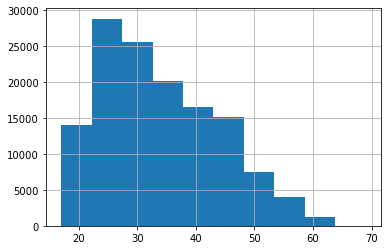

In [6]:
df['age_at_disbursal'].hist()

In [7]:
del df['date_of_birth']
del df['disbursal_date']


In [8]:
df.dtypes



uniqueid                           int64
disbursed_amount                   int64
asset_cost                         int64
ltv                              float64
employment_type                   object
sec_current_balance                int64
pri_disbursed_amount               int64
primary_instal_amt                 int64
sec_instal_amt                     int64
perform_cns_score_description     object
perform_cns_score                  int64
loan_default                       int64
pri_no_of_accts                    int64
age_at_disbursal                   int64
dtype: object

In [9]:
# remove these low values and set all not-scored to 0, these can be imputed later
df.loc[
    df['perform_cns_score_description'].str.contains('Not Scored'),
    'perform_cns_score'
] = 0

In [10]:
del df['perform_cns_score_description']


In [11]:
df.to_csv('loan_data_cleaned.csv', index=False)